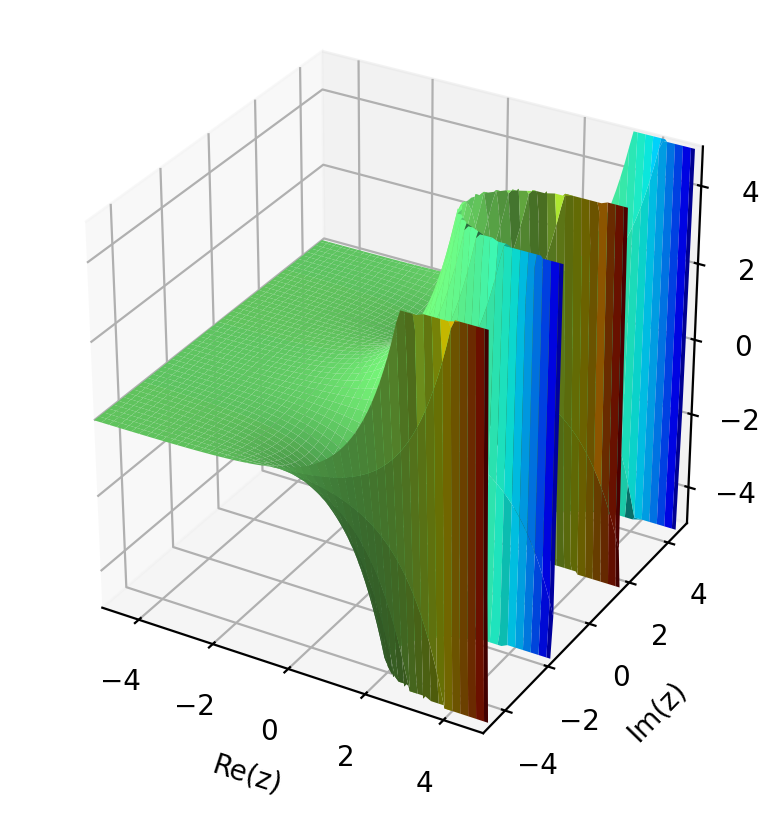

In [12]:
import numpy as np 
import matplotlib.pyplot as plt 

def zlim_masking(fz,zmin,zmax):
    valid_mask = (fz >= zmin) & (fz<= zmax)
    from scipy.ndimage import generic_filter
    def any_neighbor_valid(window):
        center = window[len(window)//2] 
        neighbors = np.concatenate([window[:4], window[5:]]) 
        return np.any(neighbors)
    # Apply to each pixel (8-connected neighborhood)
    neighbor_valid = generic_filter(
        valid_mask, 
        any_neighbor_valid, 
        size=(3, 3),  # 3x3 neighborhood
        mode='constant', 
        cval=False  # Treat edges as invalid
    )
    fz_clean = np.where(valid_mask | neighbor_valid, fz, np.nan)
    fz_clean = np.clip(fz_clean,zmin,zmax)
    return fz_clean

dx = dy = 0.1
lims = -5,5

def func(z):
    return np.exp(z)

xv = np.arange(*lims,dx) 
yv = np.arange(*lims,dy)
x,y = np.meshgrid(xv,yv) 
z = x + 1j*y

fz = func(z)

# Get components
x = z.real
y = z.imag
fz_real = fz.real
fz_imag = fz.imag  # Use magnitude of imaginary part

# fz_imag = np.clip(fz_imag,lims[0],lims[1])
fz_real = zlim_masking(fz_real,lims[0],lims[1])

norm = plt.Normalize(fz_imag.min(), fz_imag.max())
colors = plt.cm.jet(norm(fz_imag))  

fig = plt.figure(dpi = 200) 
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(
    x, y, fz_real, 
    facecolors=colors, 
    edgecolor='none',
    linewidth = 0.1,
    antialiased = True)# , cstride=1,rstride = 1)
ax.set_xlim(*lims)
ax.set_ylim(*lims)
ax.set_zlim(*lims)
# ax.set_proj_type('ortho')
# ax.view_init(elev=30, azim=120)
ax.set_box_aspect([1,1,1])
ax.set_xlabel('Re(z)')
ax.set_ylabel('Im(z)')

plt.show()

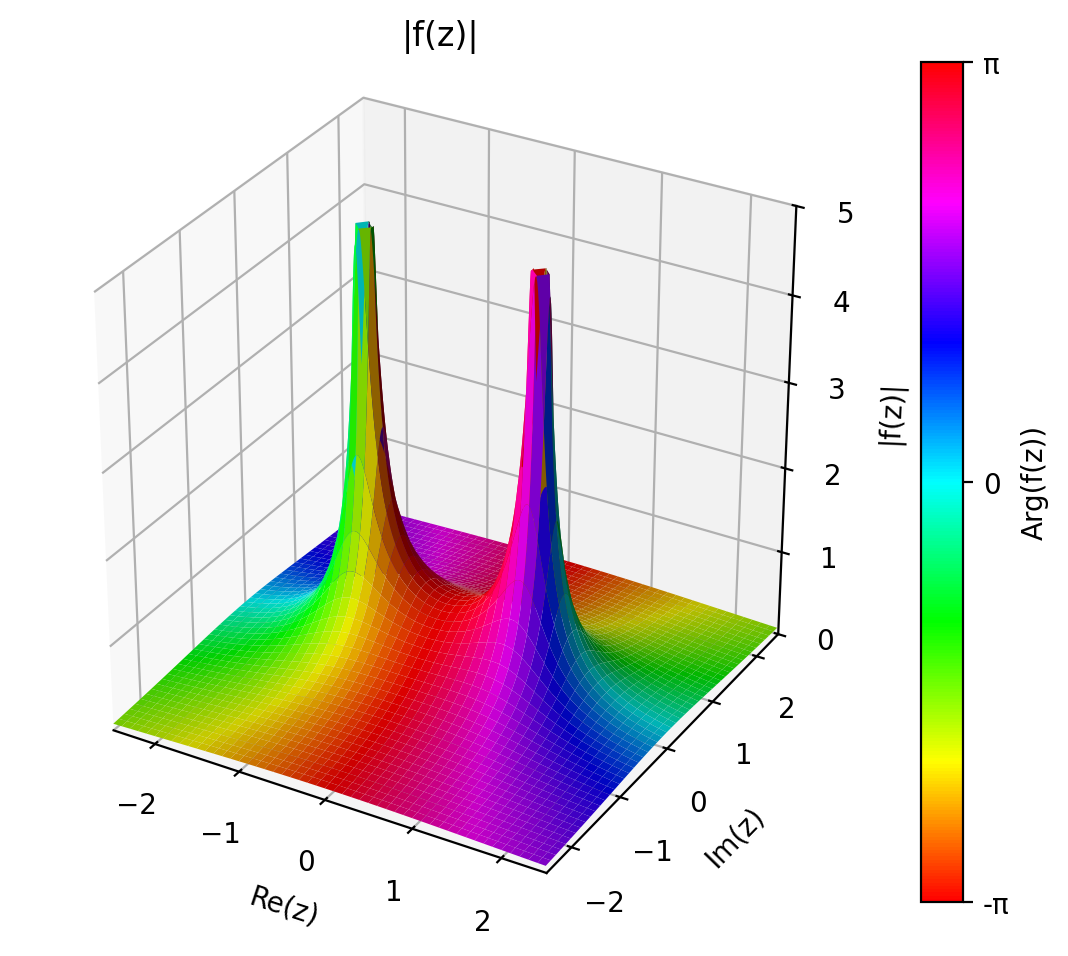

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def arg_colors(fz_arg):
    # Normalize phase to [0,1] for colormap
    arg_norm = (fz_arg + np.pi) / (2 * np.pi)  # Convert [-π,π] → [0,1]

    from matplotlib.colors import LinearSegmentedColormap
    # Custom colormap: r → y → g → c → b → m → r
    colors = [
        (1, 0, 0),    # Red
        (1, 1, 0),    # Yellow
        (0, 1, 0),    # Green
        (0, 1, 1),    # Cyan
        (0, 0, 1),    # Blue
        (1, 0, 1),    # Magenta
        (1, 0, 0)     # Red (to close the loop)
    ]
    cmap_arg = LinearSegmentedColormap.from_list('phase_colormap', colors, N=256)
    return cmap_arg(arg_norm), cmap_arg

# Domain setup
dx = dy = 0.01
lims = (-2.5, 2.5)
xv = np.arange(*lims, dx)
yv = np.arange(*lims, dy)
x, y = np.meshgrid(xv, yv)
z = x + 1j * y

def func(z):
    return 1/(z**2-1)
# Function and its properties
fz = func(z)
fz_mod = np.abs(fz)
fz_arg = np.angle(fz)  # Phase angle in radians [-π, π]
fz_mod = zlim_masking(fz_mod,0,2*lims[1])


# Create figure
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111, projection='3d')

# Plot with phase-based colors
surf = ax.plot_surface(
    x, y, np.clip(fz_mod, 0, 10),
    facecolors=arg_colors(fz_arg)[0],  # Use custom colormap
    edgecolor='none',
    antialiased=True
    #rstride=1, cstride=1
)

ax.set_xlim(*lims)
ax.set_ylim(*lims)
ax.set_zlim(0, 2*lims[1])
ax.set_box_aspect([1, 1, 1])
ax.set_xlabel('Re(z)')
ax.set_ylabel('Im(z)')
ax.set_zlabel('|f(z)|')
ax.set_title(r"|f(z)|")

# Add phase colorbar
mappable = plt.cm.ScalarMappable(cmap=arg_colors(fz_arg)[1])
mappable.set_array(np.linspace(-np.pi, np.pi, 256))
cbar = plt.colorbar(mappable, ax=ax, label='Arg(f(z))')
cbar.set_ticks([-np.pi, 0, np.pi])
cbar.set_ticklabels(['-π', '0', 'π'])

plt.tight_layout()

plt.show()

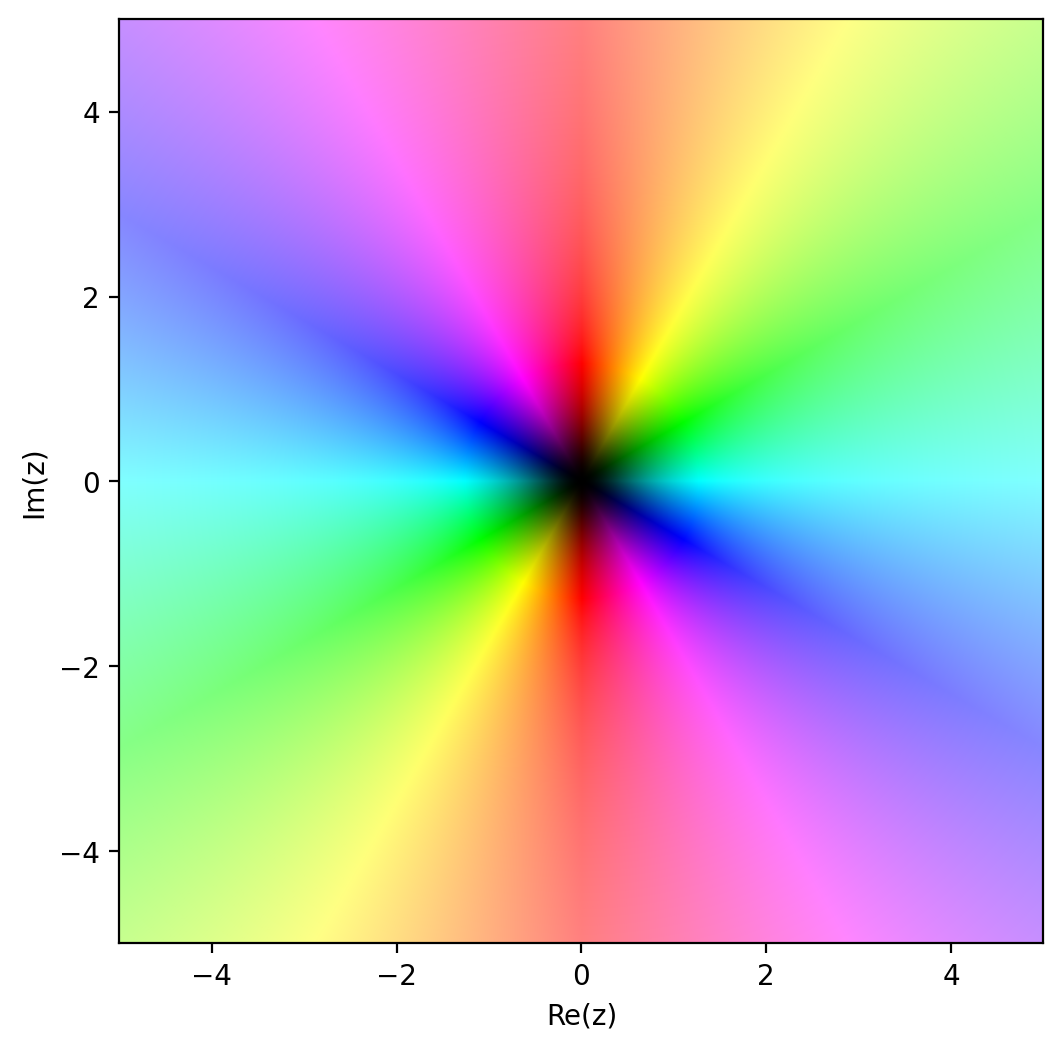

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from colorsys import hls_to_rgb

from colorsys import hls_to_rgb


def colorize(fz):

    """
    The original colorize function can be found at:
    https://stackoverflow.com/questions/17044052/mathplotlib-imshow-complex-2d-array
    by the user nadapez.
    """
    
    r = np.log2(1. + np.abs(fz))
    
    h = (np.angle(fz)+np.pi)/(2*np.pi)
    l = 1 - 0.45**(np.log(1+r)) 
    s = 1

    c = np.vectorize(hls_to_rgb)(h,l,s) # --> tuple
    c = np.array(c)  # -->  array of (3,n,m) shape, but need (m,n,3)
    c = np.rot90(c.transpose(2,1,0), 1) # Change shape to (m,n,3) and rotate 90 degrees
    
    return c

# Domain setup
dx = dy = 0.01
lims = (-5, 5)
xv = np.arange(*lims, dx)
yv = np.arange(*lims, dy)
x, y = np.meshgrid(xv, yv)
z = x + 1j*y

# Complex function
def func(z):
    return z**2#1/(z**2-1)#1/z # np.exp(z)  # Try also z**2, np.sin(z), 1/z
fz = func(z)

# Generate RGB image
rgb = colorize(fz)

# Plot
plt.figure(dpi=200, figsize=(8,6))
plt.imshow(rgb, extent=[*lims, *lims], origin='lower')
# plt.colorbar(label='Magnitude (log-scaled)')
plt.xlabel('Re(z)')
plt.ylabel('Im(z)')
plt.show()

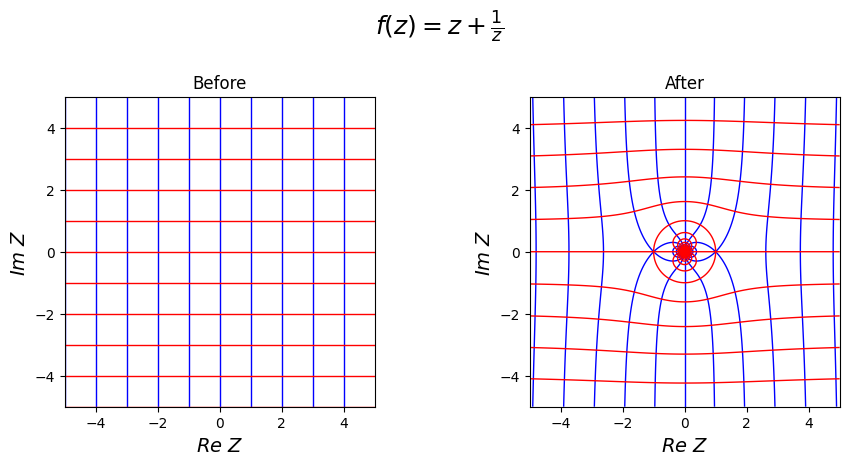

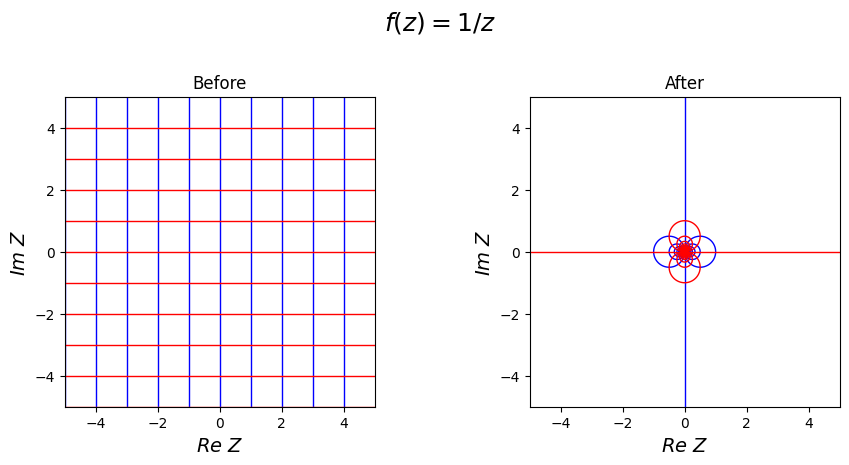

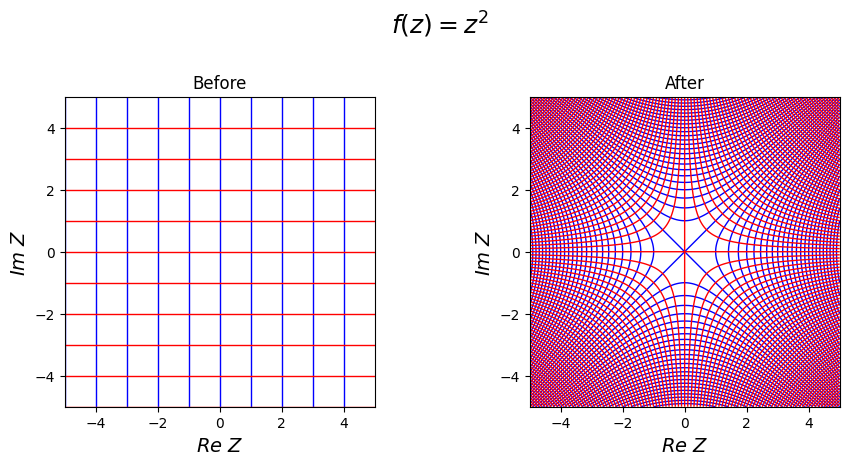

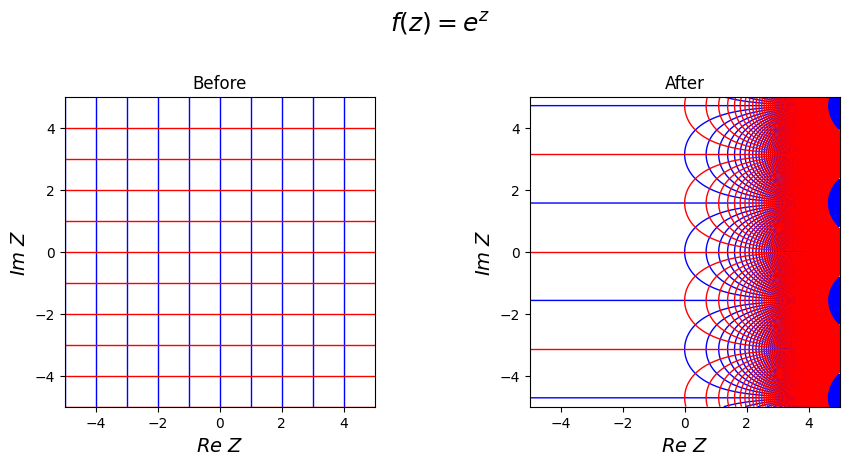

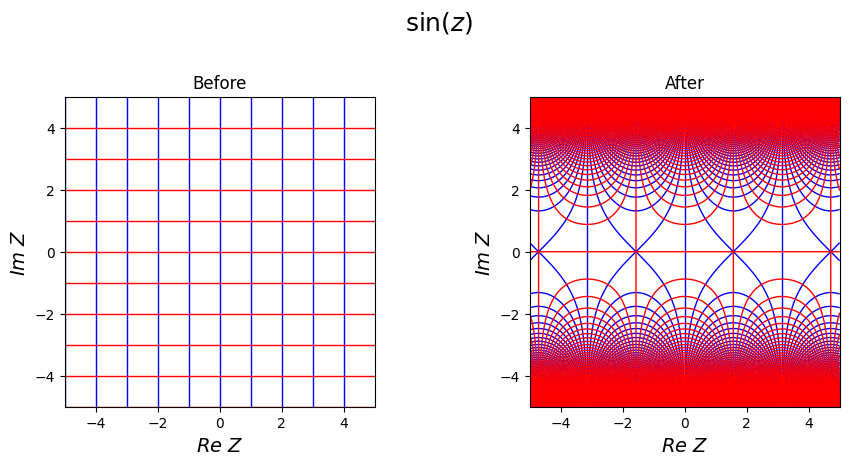

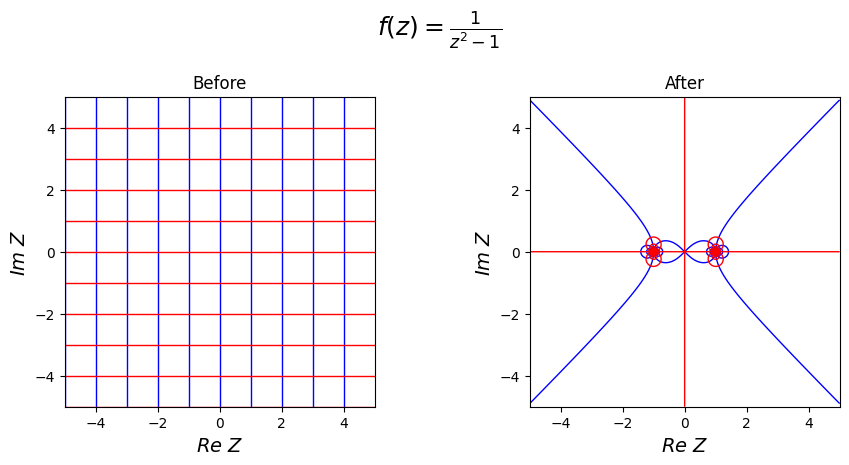

In [5]:
def func(z):
    return z + 1/z


dx = dy = 0.5
lims = -5,5
N = 300
xv = np.linspace(*lims, N)
yv = np.linspace(*lims, N)
x, y = np.meshgrid(xv, yv)

# Values of f as a function of z=x+iy
z = x+1j*y
fz = func(z)
gap = 1
lv = np.arange(-100,100,gap)

# Contours of constant Re f(z) and Im f(z) as a function of x and y

fig, (ax, ax2) = plt.subplots(1,2,figsize=(10,5))
fig.suptitle(r"$f(z)=z+\frac{1}{z}$", fontsize=18)
ax.set_aspect("equal")
ax2.set_aspect("equal")

ax.contour(xv, yv, x, colors='blue', linestyles='solid', levels=lv, linewidths=1)
ax.contour(xv, yv, y, colors='red', linestyles='solid', levels=lv, linewidths=1)
ax.set_xlabel("$Re$ $Z$", fontsize=14)
ax.set_ylabel("$Im$ $Z$", fontsize=14)
ax.set_title("Before")

ax2.contour(xv, yv, np.real(fz), colors='blue', linestyles='solid', levels=lv, linewidths=1)
ax2.contour(xv, yv, np.imag(fz), colors='red', linestyles='solid', levels=lv, linewidths=1)
ax2.set_xlabel("$Re$ $Z$", fontsize=14)
ax2.set_ylabel("$Im$ $Z$", fontsize=14)
ax2.set_title("After")

plt.subplots_adjust(wspace=0.5)
plt.show()

fz = 1/z
gap = 1
lv = np.arange(-100,100,gap)

# Contours of constant Re f(z) and Im f(z) as a function of x and y

fig, (ax, ax2) = plt.subplots(1,2,figsize=(10,5))
fig.suptitle(r"$f(z)=1/z$", fontsize=18)
ax.set_aspect("equal")
ax2.set_aspect("equal")

ax.contour(xv, yv, x, colors='blue', linestyles='solid', levels=lv, linewidths=1)
ax.contour(xv, yv, y, colors='red', linestyles='solid', levels=lv, linewidths=1)
ax.set_xlabel("$Re$ $Z$", fontsize=14)
ax.set_ylabel("$Im$ $Z$", fontsize=14)
ax.set_title("Before")

ax2.contour(xv, yv, np.real(fz), colors='blue', linestyles='solid', levels=lv, linewidths=1)
ax2.contour(xv, yv, np.imag(fz), colors='red', linestyles='solid', levels=lv, linewidths=1)
ax2.set_xlabel("$Re$ $Z$", fontsize=14)
ax2.set_ylabel("$Im$ $Z$", fontsize=14)
ax2.set_title("After")

plt.subplots_adjust(wspace=0.5)
plt.show()

fz = z**2
gap = 1
lv = np.arange(-100,100,gap)

# Contours of constant Re f(z) and Im f(z) as a function of x and y

fig, (ax, ax2) = plt.subplots(1,2,figsize=(10,5))
fig.suptitle(r"$f(z)=z^2$", fontsize=18)
ax.set_aspect("equal")
ax2.set_aspect("equal")

ax.contour(xv, yv, x, colors='blue', linestyles='solid', levels=lv, linewidths=1)
ax.contour(xv, yv, y, colors='red', linestyles='solid', levels=lv, linewidths=1)
ax.set_xlabel("$Re$ $Z$", fontsize=14)
ax.set_ylabel("$Im$ $Z$", fontsize=14)
ax.set_title("Before")

ax2.contour(xv, yv, np.real(fz), colors='blue', linestyles='solid', levels=lv, linewidths=1)
ax2.contour(xv, yv, np.imag(fz), colors='red', linestyles='solid', levels=lv, linewidths=1)
ax2.set_xlabel("$Re$ $Z$", fontsize=14)
ax2.set_ylabel("$Im$ $Z$", fontsize=14)
ax2.set_title("After")

plt.subplots_adjust(wspace=0.5)
plt.show()

fz = np.exp(z)
gap = 1
lv = np.arange(-100,100,gap)

# Contours of constant Re f(z) and Im f(z) as a function of x and y

fig, (ax, ax2) = plt.subplots(1,2,figsize=(10,5))
fig.suptitle(r"$f(z)=e^{z}$", fontsize=18)
ax.set_aspect("equal")
ax2.set_aspect("equal")

ax.contour(xv, yv, x, colors='blue', linestyles='solid', levels=lv, linewidths=1)
ax.contour(xv, yv, y, colors='red', linestyles='solid', levels=lv, linewidths=1)
ax.set_xlabel("$Re$ $Z$", fontsize=14)
ax.set_ylabel("$Im$ $Z$", fontsize=14)
ax.set_title("Before")

ax2.contour(xv, yv, np.real(fz), colors='blue', linestyles='solid', levels=lv, linewidths=1)
ax2.contour(xv, yv, np.imag(fz), colors='red', linestyles='solid', levels=lv, linewidths=1)
ax2.set_xlabel("$Re$ $Z$", fontsize=14)
ax2.set_ylabel("$Im$ $Z$", fontsize=14)
ax2.set_title("After")

plt.subplots_adjust(wspace=0.5)
plt.show()

fz = np.sin(z)
gap = 1
lv = np.arange(-100,100,gap)

# Contours of constant Re f(z) and Im f(z) as a function of x and y

fig, (ax, ax2) = plt.subplots(1,2,figsize=(10,5))
fig.suptitle(r"$\sin(z)$", fontsize=18)
ax.set_aspect("equal")
ax2.set_aspect("equal")

ax.contour(xv, yv, x, colors='blue', linestyles='solid', levels=lv, linewidths=1)
ax.contour(xv, yv, y, colors='red', linestyles='solid', levels=lv, linewidths=1)
ax.set_xlabel("$Re$ $Z$", fontsize=14)
ax.set_ylabel("$Im$ $Z$", fontsize=14)
ax.set_title("Before")

ax2.contour(xv, yv, np.real(fz), colors='blue', linestyles='solid', levels=lv, linewidths=1)
ax2.contour(xv, yv, np.imag(fz), colors='red', linestyles='solid', levels=lv, linewidths=1)
ax2.set_xlabel("$Re$ $Z$", fontsize=14)
ax2.set_ylabel("$Im$ $Z$", fontsize=14)
ax2.set_title("After")

plt.subplots_adjust(wspace=0.5)
plt.show()

fz = 1/(z**2-1)
gap = 1
lv = np.arange(-100,100,gap)

# Contours of constant Re f(z) and Im f(z) as a function of x and y

fig, (ax, ax2) = plt.subplots(1,2,figsize=(10,5))
fig.suptitle(r"$f(z)=\frac{1}{z^2-1}$", fontsize=18)
ax.set_aspect("equal")
ax2.set_aspect("equal")

ax.contour(xv, yv, x, colors='blue', linestyles='solid', levels=lv, linewidths=1)
ax.contour(xv, yv, y, colors='red', linestyles='solid', levels=lv, linewidths=1)
ax.set_xlabel("$Re$ $Z$", fontsize=14)
ax.set_ylabel("$Im$ $Z$", fontsize=14)
ax.set_title("Before")

ax2.contour(xv, yv, np.real(fz), colors='blue', linestyles='solid', levels=lv, linewidths=1)
ax2.contour(xv, yv, np.imag(fz), colors='red', linestyles='solid', levels=lv, linewidths=1)
ax2.set_xlabel("$Re$ $Z$", fontsize=14)
ax2.set_ylabel("$Im$ $Z$", fontsize=14)
ax2.set_title("After")

plt.subplots_adjust(wspace=0.5)
plt.show()

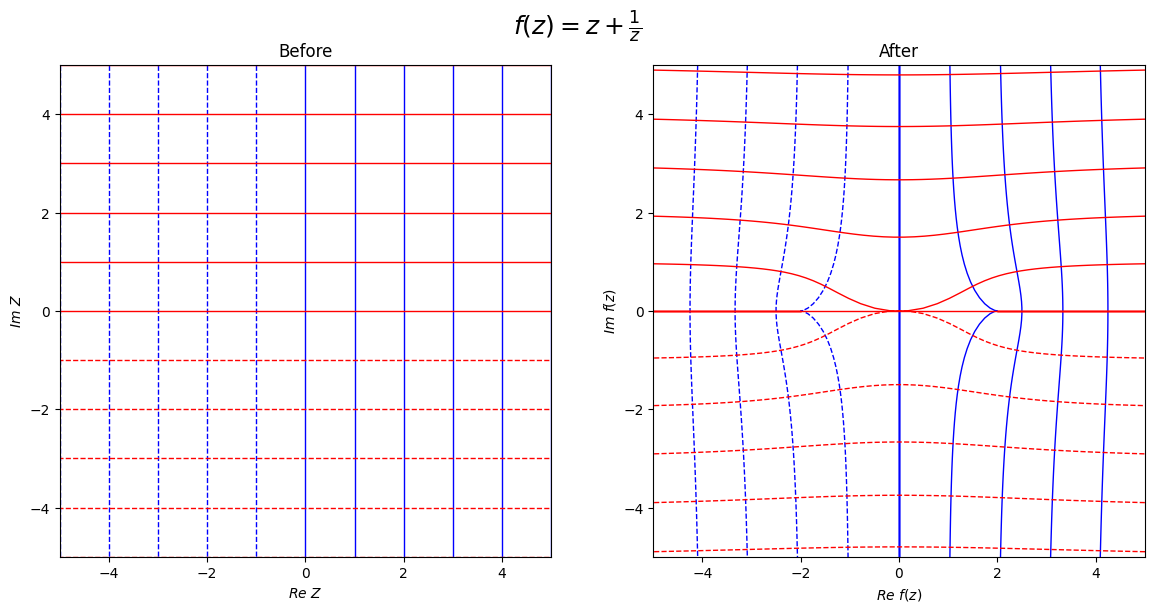

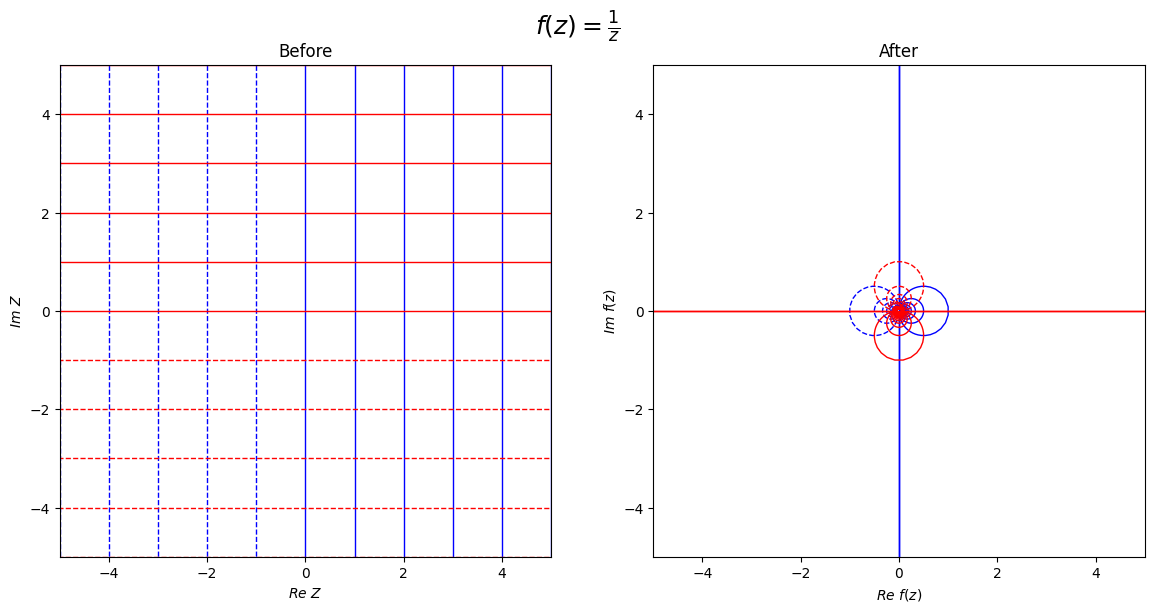

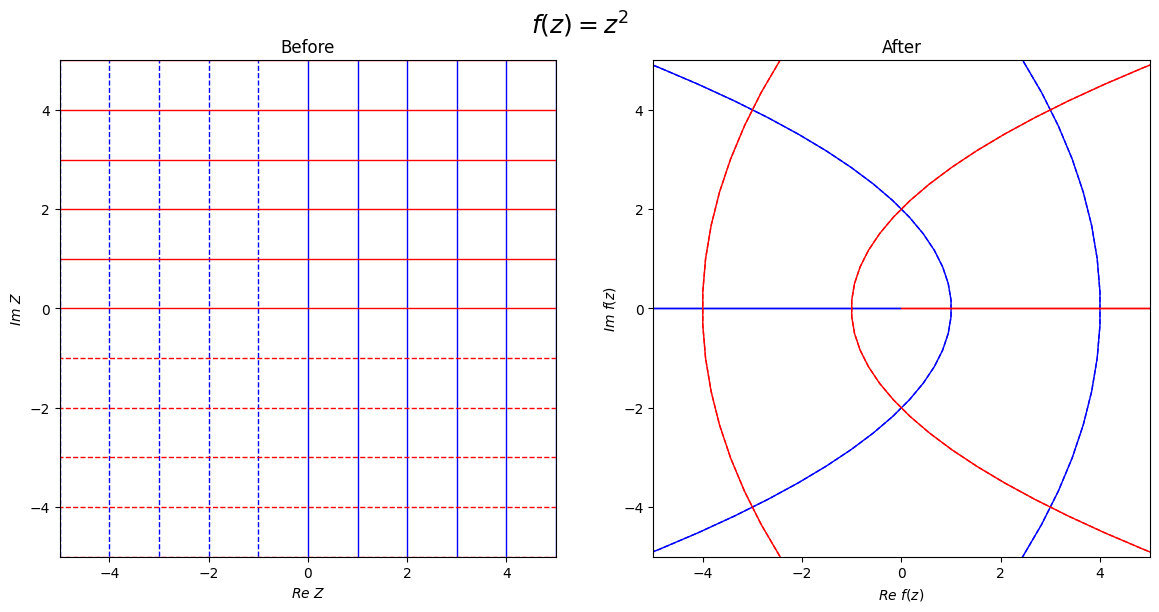

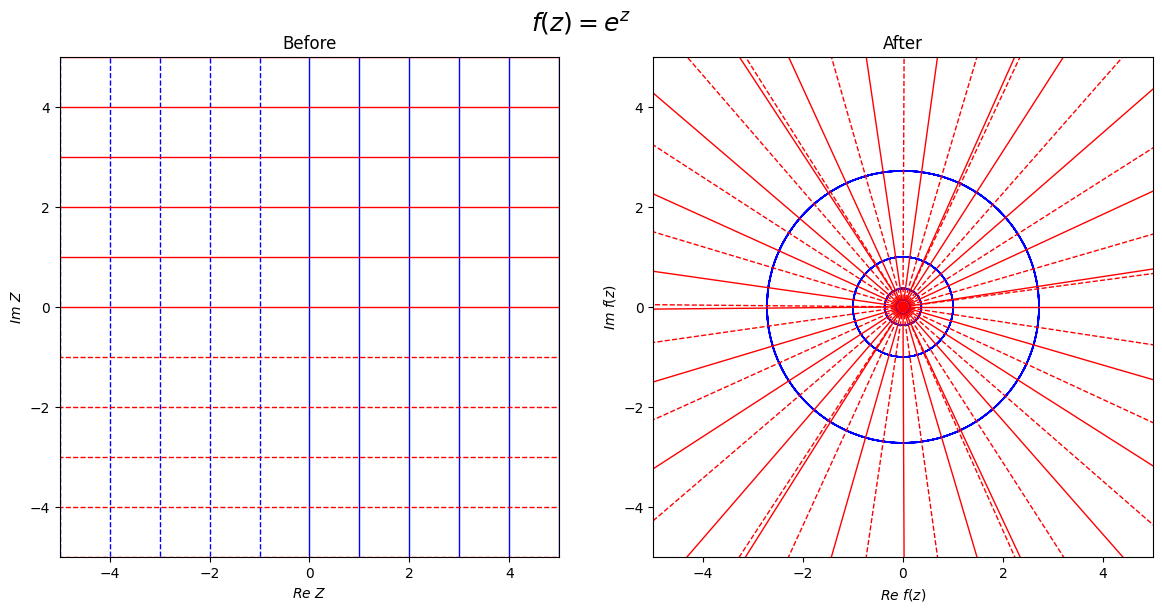

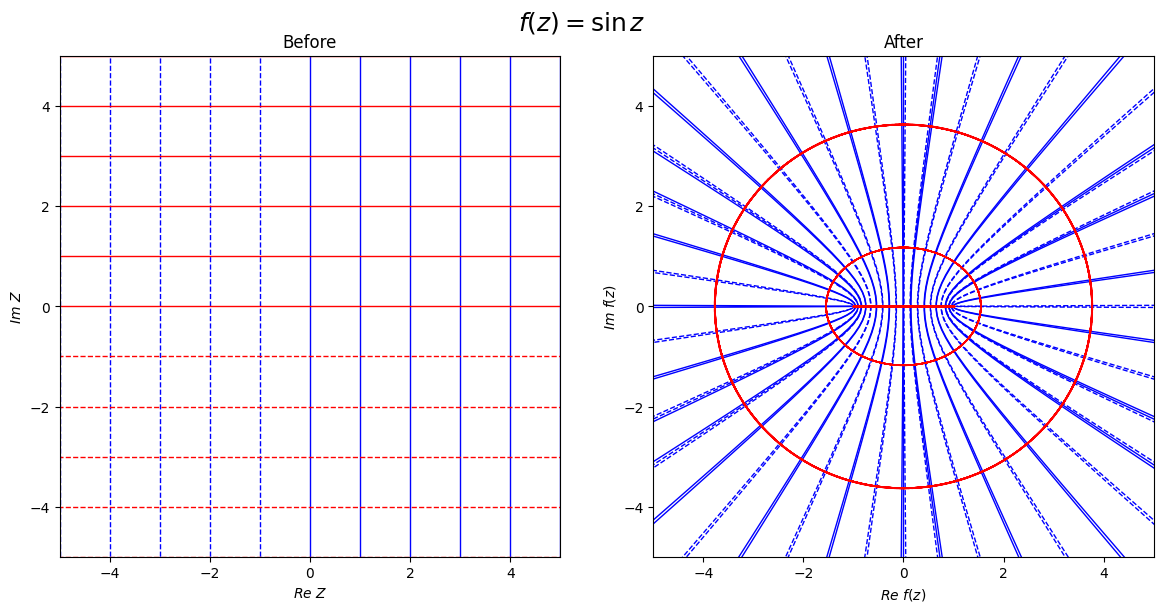

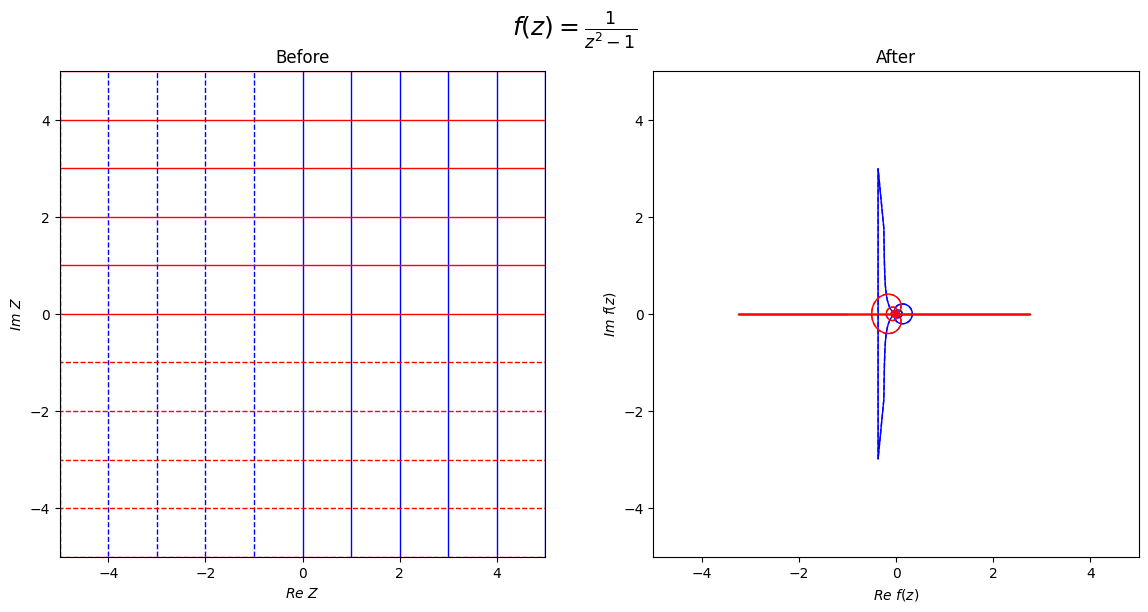

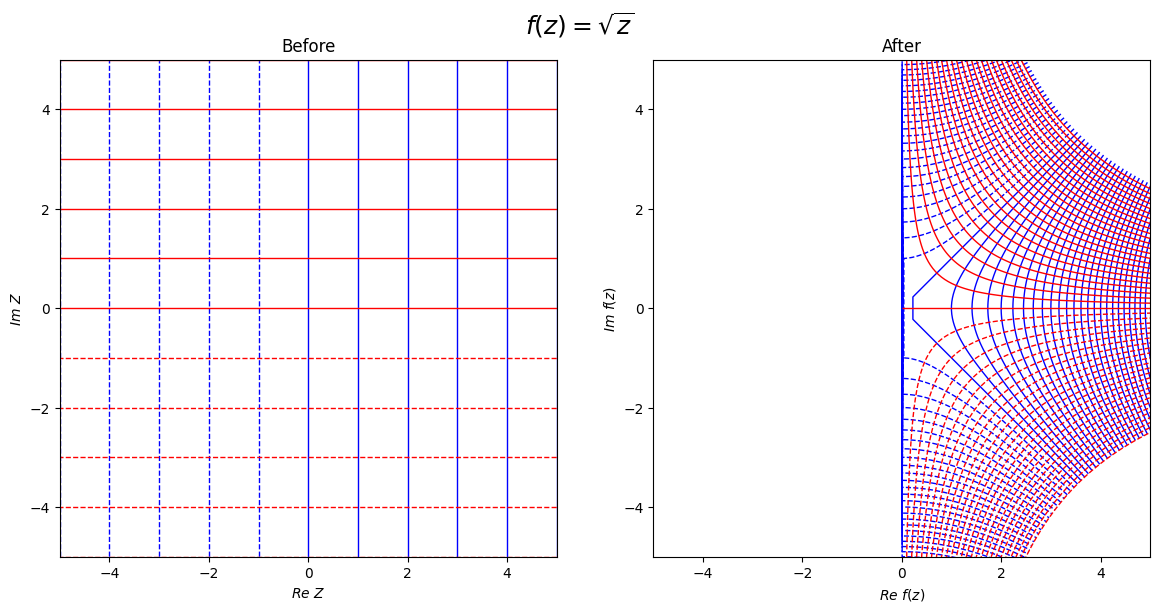

In [6]:
import numpy as np
import matplotlib.pyplot as plt

dx = dy = 0.5
lims = -5, 5
N = 300
xv = np.linspace(5*lims[0],5*lims[1], N)
yv = np.linspace(5*lims[0],5*lims[1], N)
x, y = np.meshgrid(xv, yv)

# Values of f as a function of z=x+iy
z = x + 1j*y

def func(z):
    return z**2

def plot_transform(fz, title):
    gap = 1
    lv = np.arange(-100, 100, gap)

    # Create figure
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(title, fontsize=18)

    # Before transformation
    ax.contour(x, y, x, colors='blue', levels=lv, linewidths=1)
    ax.contour(x, y, y, colors='red', levels=lv, linewidths=1)
    ax.set(xlabel="$Re$ $Z$", ylabel="$Im$ $Z$", title="Before",
        xlim=lims, ylim=lims, aspect="equal")

    # After transformation - mask near singularity
    with np.errstate(divide='ignore', invalid='ignore'):
        fz = fz
        mask = np.abs(z) > 0.1  # Avoid z=0 singularity
        fz[~mask] = np.nan

    ax2.contour(np.real(fz), np.imag(fz), x, colors='blue', levels=lv, linewidths=1)
    ax2.contour(np.real(fz), np.imag(fz), y, colors='red', levels=lv, linewidths=1)
    ax2.set(xlabel="$Re$ $f(z)$", ylabel="$Im$ $f(z)$", title="After",
            aspect="equal", xlim=(-5, 5), ylim=(-5, 5))

    plt.tight_layout()
    plt.show()

plot_transform(z+1/z, r'$f(z)=z+\frac{1}{z}$')
plot_transform(1/z, r'$f(z)=\frac{1}{z}$')
plot_transform(z**2, r'$f(z)=z^2$')
plot_transform(np.exp(z), r'$f(z)=e^z$')
plot_transform(np.sin(z), r'$f(z)=\sin z$')
plot_transform(1/(z**2-1), r'$f(z)=\frac{1}{z^2-1}$')
plot_transform(np.sqrt(z), r'$f(z)=\sqrt{z}$')

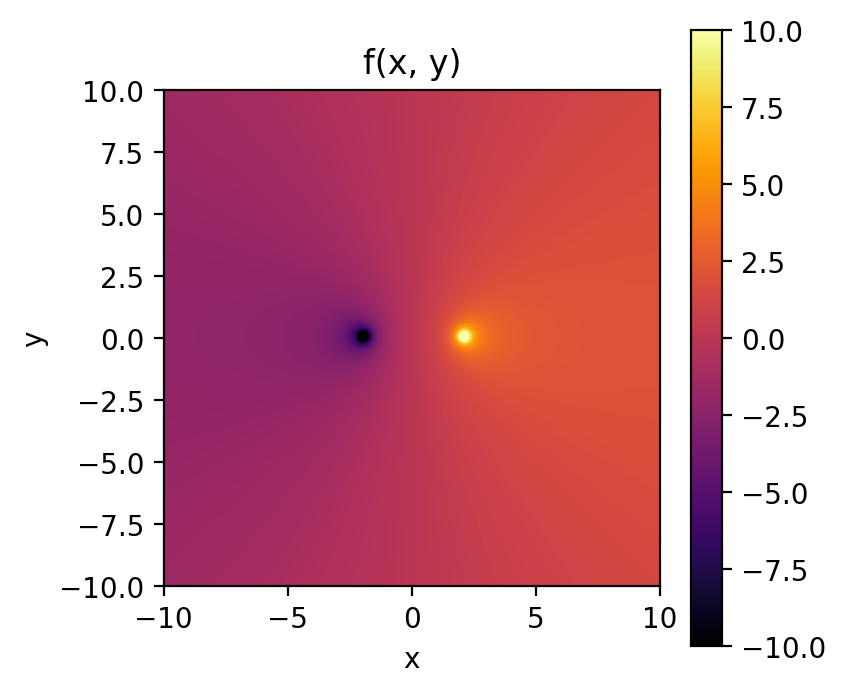

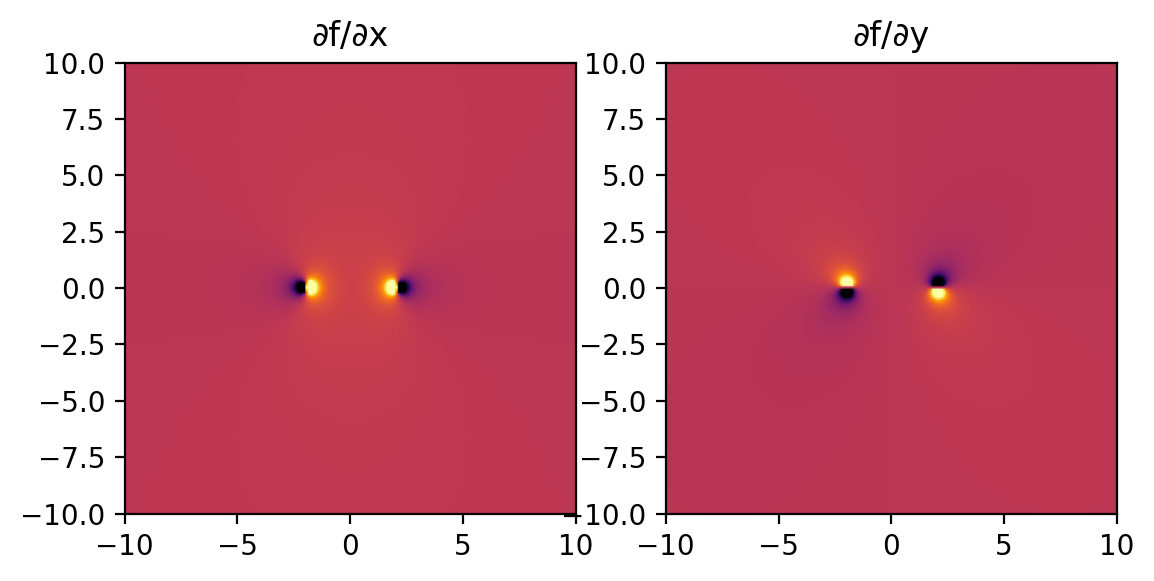

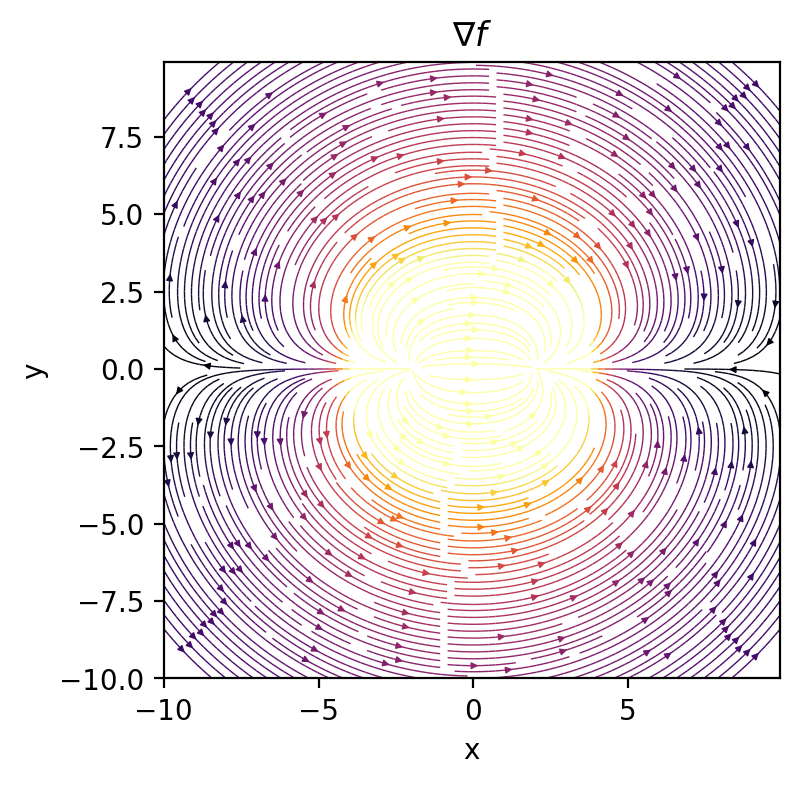

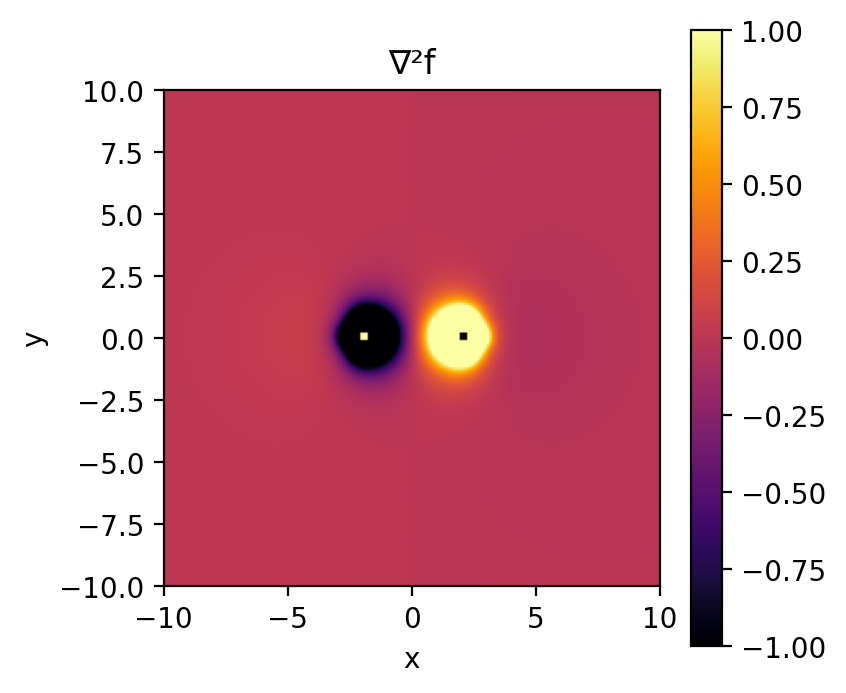

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Domain
lims = -10, 10
dx = 0.1
dy = 0.1
x = np.arange(*lims, dx)
y = np.arange(*lims, dy)
X, Y = np.meshgrid(x, y)  


vims = -10,10
# Function definition
def scalar_function(x, y):
    a = 2
    return   x / np.sqrt((x-a)**2+y**2) +  x / np.sqrt((x+a)**2+y**2) 

# discovered functions, do not touch
def weird_field(x, y):
    a = 2
    return   x / np.sqrt((x-a)**2+y**2) +  x / np.sqrt((x+a)**2+y**2) 

def separable_dipole(x, y):
    a = 0.1
    return   1 / np.sqrt((x-a)**2+y**2) -  1 / np.sqrt((x+a)**2+y**2) 

def quadrupole(x, y):
    return   (x*y-y*y)/((x*x+y*y)**2)
def weird_ahh_potential(x, y):
    return  x / np.sqrt(x*x+y*y)
def a2D_dipole(x, y):
    return  y / (x*x+y*y)
def monopole(x, y):
    return 1 / np.sqrt(x*x+y*y)
def ring_potential(x, y):
    return  np.exp(-(np.sqrt(x*x+y*y)-3)**2)

Z = scalar_function(X, Y)

# Show the scalar field
plt.figure(dpi=200, figsize=(4, 4))
plt.imshow(Z, cmap='inferno', extent=[*lims, *lims], origin='lower', aspect='equal', vmin=vims[0], vmax=vims[1])
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("f(x, y)")
plt.show()

# Gradient components
dZdx = np.gradient(Z, axis=1) / dx  # ∂Z/∂x
dZdy = np.gradient(Z, axis=0) / dy  # ∂Z/∂y

# Visualize gradient components
fig, ax = plt.subplots(1,2,dpi = 200)
ax[0].imshow(dZdx, cmap="inferno", extent=[*lims, *lims], origin='lower', aspect='equal', vmin=vims[0], vmax=vims[1])
ax[0].set_title("∂f/∂x")

ax[1].imshow(dZdy, cmap="inferno", extent=[*lims, *lims], origin='lower', aspect='equal', vmin=vims[0], vmax=vims[1])
ax[1].set_title("∂f/∂y")
plt.show()

# Vector field
# step = 5  # Show every 5th vector
# plt.figure(dpi=200, figsize=(4, 4))
# plt.quiver(
#     X[::step, ::step],
#     Y[::step, ::step],
#     dZdx[::step, ::step],
#     dZdy[::step, ::step]
# )
# # plt.title()
# plt.show()

# Streamplot
plt.figure(dpi=200, figsize=(4, 4))
plt.streamplot(x, y, dZdx, dZdy, color=np.clip(np.hypot(dZdx, dZdy),0,0.5), cmap='inferno', density=3,linewidth = 0.5, arrowsize=0.5)
plt.title(r"$\nabla f$")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect('equal')
# plt.colorbar(label="Gradient Magnitude")
plt.show()

## Divergence of the field
# Second derivatives (for divergence/Laplacian)
d2Zdx2 = np.gradient(dZdx, axis=1) / dx  # ∂²f/∂x²
d2Zdy2 = np.gradient(dZdy, axis=0) / dy  # ∂²f/∂y²

# Divergence (Laplacian) = d2Zdx2 + d2Zdy2
divergence = d2Zdx2 + d2Zdy2

# Plot divergence
plt.figure(dpi=200, figsize=(4, 4))
plt.imshow(divergence, cmap='inferno', extent=[*lims, *lims], origin='lower', aspect='equal', vmin=vims[0]/10, vmax=vims[1]/10)
plt.colorbar()
plt.title("∇²f")
plt.xlabel("x")
plt.ylabel("y")
plt.show()



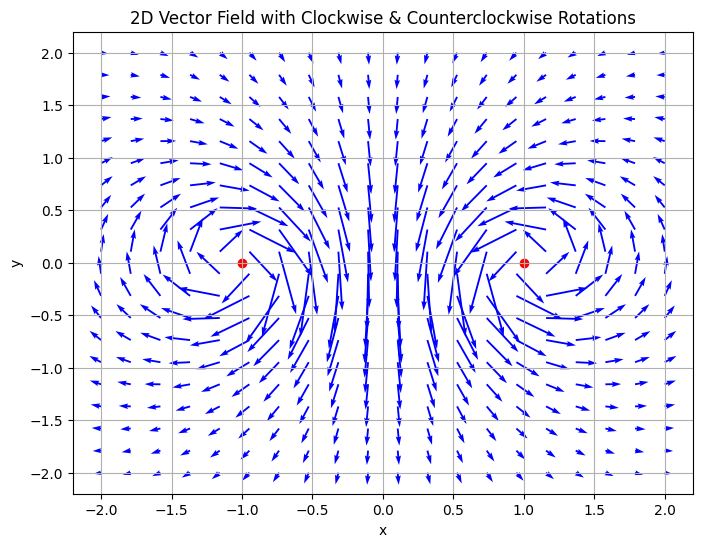

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

a = 1.0  # Distance parameter
C = 1.0  # Strength of vortices
eps = 0.1  # Small regularization term

def velocity_field(x, y):
    # Clockwise vortex at (-a, 0)
    v1x = C * (y) / ((x + a)**2 + y**2 + eps)
    v1y = C * (-(x + a)) / ((x + a)**2 + y**2 + eps)
    
    # Counterclockwise vortex at (a, 0)
    v2x = C * (-y) / ((x - a)**2 + y**2 + eps)
    v2y = C * (x - a) / ((x - a)**2 + y**2 + eps)
    
    return v1x + v2x, v1y + v2y

# Create grid
x = np.linspace(-2, 2, 20)
y = np.linspace(-2, 2, 20)
X, Y = np.meshgrid(x, y)

# Compute vector field
Vx, Vy = velocity_field(X, Y)

# Plot
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, Vx, Vy, color='blue', scale=20)
plt.scatter([-a, a], [0, 0], color='red')  # Mark vortex centers
plt.title("2D Vector Field with Clockwise & Counterclockwise Rotations")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()



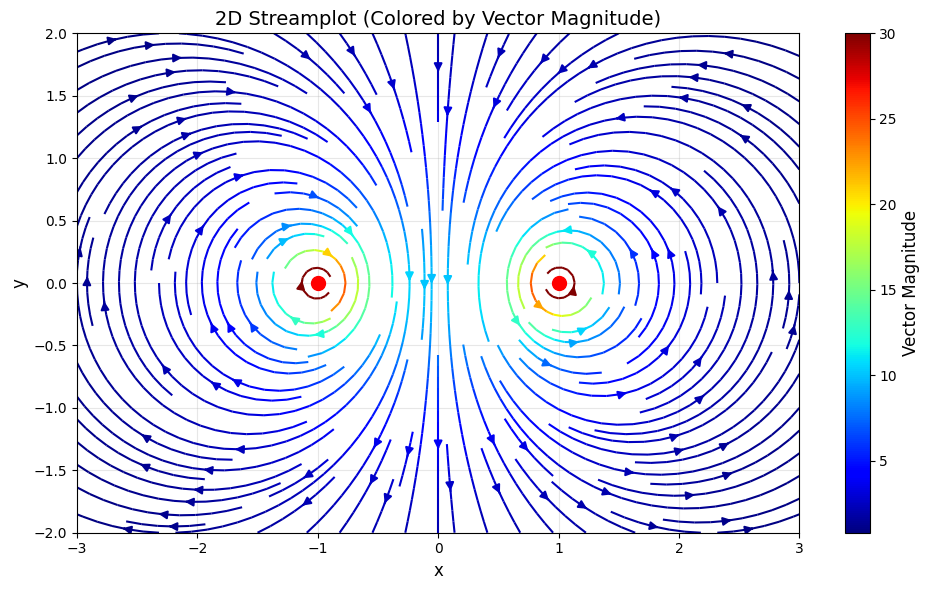

In [18]:
import numpy as np
import matplotlib.pyplot as plt

a = 1      # Distance between vortices
C = 5.0      # Strength of vortices
eps = 0.00   # Small regularization to avoid division by zero

def velocity_field(x, y):
    # Clockwise vortex at (-a, 0)
    v1x = C * (y) / ((x + a)**2 + y**2 + eps)
    v1y = C * (-(x + a)) / ((x + a)**2 + y**2 + eps)
    
    # Counterclockwise vortex at (a, 0)
    v2x = C * (-y) / ((x - a)**2 + y**2 + eps)
    v2y = C * (x - a) / ((x - a)**2 + y**2 + eps)
    
    return v1x + v2x, v1y + v2y

# Create a fine grid
x = np.linspace(-3, 3, 150)
y = np.linspace(-2, 2, 150)
X, Y = np.meshgrid(x, y)

# Compute the vector field and its magnitude
Vx, Vy = velocity_field(X, Y)
V_mag = np.sqrt(Vx**2 + Vy**2)  # Magnitude of the vector field

# Normalize magnitude for better colormap scaling
V_mag_normalized = (V_mag - V_mag.min()) / (V_mag.max() - V_mag.min())

# Create the streamplot with color mapping
plt.figure(figsize=(10, 6))
strm = plt.streamplot(
    X, Y, Vx, Vy, 
    color=np.clip(V_mag,0,30),                # Color by magnitude
    cmap='jet',            # Use the 'inferno' colormap
    density=1.5,               # Controls streamline spacing
    linewidth=1.5,             # Thickness of streamlines
    arrowsize=1.2,             # Size of directional arrows
)

# Add a colorbar to show magnitude
cbar = plt.colorbar(strm.lines)
cbar.set_label('Vector Magnitude', fontsize=12)

# Mark the vortex centers
plt.scatter([-a, a], [0, 0], color='red', s=100, zorder=5)

plt.title("2D Streamplot (Colored by Vector Magnitude)", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

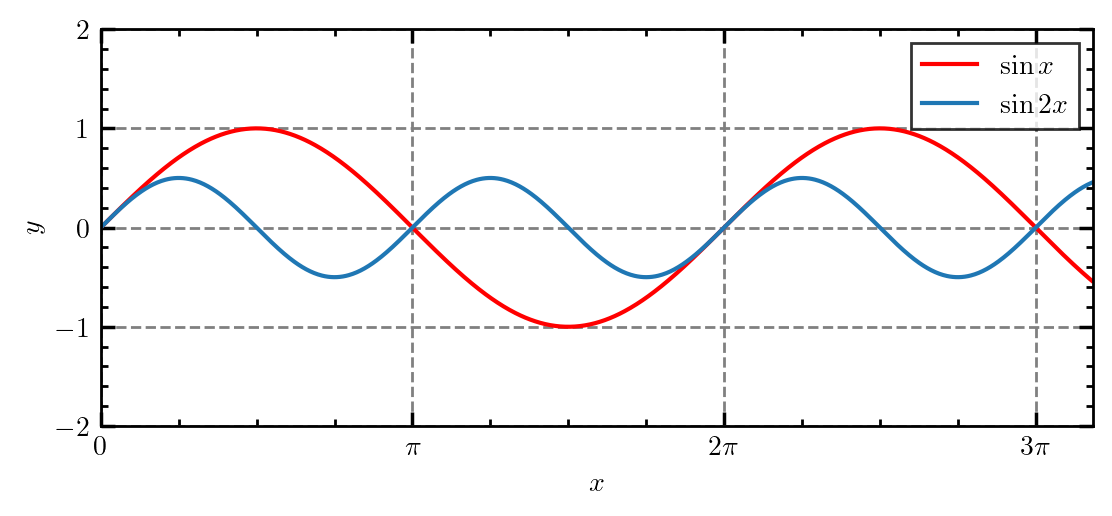

In [46]:
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams.update({
        'legend.fancybox' : False,       # Disable the fancy box for legend
        'legend.edgecolor': 'k',         # Set legend border color to black

        'text.usetex'     : True,        # Use LaTeX for text rendering
        'font.family'     : 'serif'      # Set font family to serif
    })
dx = 0.01 
x = np.arange(0,10,dx)
y = np.sin(x)

plt.figure(dpi=200)
plt.plot(x,y,'r', label = r"$\sin x$")
plt.plot(x,np.sin(x)*np.cos(x), label = r'$\sin 2x$')

plt.grid(True, linestyle = "--", color = "gray", linewidth=1)
# plt.grid(which='minor', linewidth=0.75, linestyle='--')
plt.minorticks_on()
plt.tick_params(which="both",direction="in")
plt.tick_params(which='minor', length=2.5, color='k', width = 1,
               top=True, bottom=True, left=True, right=True)
plt.tick_params(axis='both', which='major', width=1.25, length = 5,
                top=True, bottom=True, left=True, right=True)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1)

plt.gca().set_aspect("equal")

plt.xlim(0,10)
plt.ylim(-2,2)

plt.xticks(np.arange(0,3.1*np.pi,np.pi),['0',r'$\pi$',r"$2\pi$",r"$3\pi$"]) # you can pass the labels here also 

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()

In [ ]:
plt.rcParams.update({
    # Grid settings
    "grid.linestyle": "--",
    "grid.color": "gray",
    "grid.linewidth": 1,
    "axes.grid": True,

    # Minor grid
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,

    # Tick settings (both major & minor)
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "xtick.bottom": True,
    "ytick.left": True,
    "ytick.right": True,

    # Major ticks
    "xtick.major.width": 1,
    "ytick.major.width": 1,
    "xtick.major.size": 5,
    "ytick.major.size": 5,

    # Minor ticks
    "xtick.minor.width": 1,
    "ytick.minor.width": 1,
    "xtick.minor.size": 2.5,
    "ytick.minor.size": 2.5,

    # Spine (border) width
    "axes.linewidth": 1
})